In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import time

f_train = open(os.path.join('facedata','facedatatrain'),'r')
f_train_label = open(os.path.join('facedata','facedatatrainlabels'),'r')
f_test = open(os.path.join('facedata','facedatatest'),'r')
f_test_label = open(os.path.join('facedata','facedatatestlabels'),'r')
f_val = open(os.path.join('facedata','facedatavalidation'),'r')
f_val_label = open(os.path.join('facedata','facedatavalidationlabels'),'r') 

In [2]:
def makelabels(file,num):
    labels = np.zeros(num)
    for i in range(num):
        c = file.read(1)
        labels[i] = int(c)
        c_we = file.read(1)
    return labels
        
def makefaces(file,num,height,width):
    train = np.zeros((num,height,width))
    for k in range(num):
        img = np.zeros((height,width))
        for i in range(height):
            for j in range(width):
                c = file.read(1)
                if c == '#':
                    img[i][j] = 255
            c = file.read(1)
        train[k,:,:] = img
    return train

## Create Train and Test Sets 
### Display Sample Image

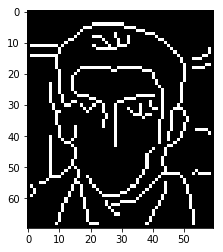

In [3]:
%matplotlib inline
train = makefaces(f_train,451,70,60)
train_labels = makelabels(f_train_label,451)
test = makefaces(f_test,150,70,60)
test_labels = makelabels(f_test_label,150)
val = makefaces(f_val,301,70,60)
val_labels = makelabels(f_val_label,301)
plt.imshow(train[78],cmap='gray')

In [ ]:
train = np.array([i.flatten() for i in train])
test = np.array([i.flatten() for i in test]) 
train_MxN = train.transpose()
test_MxN = test.transpose()

# Naive Bayes Classifier using discrete pixel probabilities

In [9]:
# -------------- NAIVE BAYES CLASSIFIER --------------------

def NBC(data,labels,testdata):
    ## data in shape MxN, where M = # of features
    numFeat = data.shape[0]
    LabelData = [{'class':x, 'index':i} for i,x in enumerate(labels)] 
    #print(LabelData)
    ClassData = []
    numclasses = 2
    for i in range(numclasses):
        newclass = list(filter(lambda x: x['class']==i, LabelData))
        ClassData.append(newclass)
       
    P = []
    for i in range(numclasses):
        newp = len(ClassData[i])/len(LabelData)
        P.append(newp)
        
    #M = stddata.shape[0]
    probFeat = np.zeros((numclasses,numFeat,2))
    ClassFeat = np.zeros((numclasses,numFeat,2))
           
    for k in range(numclasses):
        for i in range(len(ClassData[k])):
            idx = ClassData[k][i]['index']
            for j in range(numFeat):
                if data[j][idx] == 0:
                    #print(data[j][idx])
                    ClassFeat[k][j][0] += 1
                else:
                    ClassFeat[k][j][1] += 1
                
        for j in range(numFeat):
            probFeat[k][j][0] = ClassFeat[k][j][0]/len(ClassData[k])
            probFeat[k][j][1] = ClassFeat[k][j][1]/len(ClassData[k])
            assert (probFeat[k][j][0] + probFeat[k][j][1]) == 1
            
                
    predictions = []
    for i in range(testdata.shape[1]):
        p = []
        for k in range(numclasses):
            pclass = P[k]
            for j in range(1500,3000):
                if testdata[j][i] == 0:
                    pclass = pclass * probFeat[k][j][0]
                else:
                    pclass = pclass * probFeat[k][j][1]
                
            p.append(pclass)
        predictions.append(p.index(max(p)))
    return predictions

def counterror(pred,labels):
    count = 0;
    for i in range(len(pred)):
        if (pred[i] != int(labels[i])):
            count = count +1
    acc = 1 - count/labels.shape[0]
    return count, acc

In [14]:
start_time = time.clock()
pred = NBC(train_MxN, train_labels, test_MxN)
time_ = time.clock() - start_time
errorcount, accu = counterror(pred,test_labels)
print("NBC Accuracy is: ", accu)
print("Time is: ", time_)

NBC Accuracy is:  0.88
Time is:  2.005154100000027


# Perceptron Classifier using Unit Step Function

In [12]:
# ------------------- PERCEPTRON using Unit Step Function --------------

def predict(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        activation += weights[i + 1] * row[i]
    return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def train_weights(train, l_rate, n_epoch):
    weights = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        sum_error = 0.0
        for row in train:
            prediction = predict(row, weights)
            error = row[-1] - prediction
            sum_error += error**2
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row)-1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return weights

# Perceptron Algorithm With Stochastic Gradient Descent
def perceptron(train, test, l_rate, n_epoch):
    predictions = list()
    weights = train_weights(train, l_rate, n_epoch)
    for row in test:
        prediction = predict(row, weights)
        predictions.append(prediction)
    return(predictions)

def accuracy(expected, predicted):
    error_count = 0
    for i in range(0, len(expected)):
        if(predicted[i]!=expected[i]):
            error_count = error_count + 1
    acc = (len(expected)-error_count)/len(expected)
    return error_count, acc


In [15]:
train_data = np.column_stack((train,train_labels))
print(train_data.shape)
test_data = np.column_stack((test, test_labels))
print(test_data.shape)
l_rate = 0.01
n_epoch = 7
start_time = time.clock()
pred = perceptron(train_data, test_data, l_rate, n_epoch)
time_ = time.clock() - start_time
err, accu = accuracy(test_labels, pred)
print("Perceptron Accuracy is: ", accu)
print("Time: ", time_)

(451, 4201)
(150, 4201)
>epoch=0, lrate=0.010, error=121.000
>epoch=1, lrate=0.010, error=41.000
>epoch=2, lrate=0.010, error=10.000
>epoch=3, lrate=0.010, error=2.000
>epoch=4, lrate=0.010, error=4.000
>epoch=5, lrate=0.010, error=5.000
>epoch=6, lrate=0.010, error=5.000
Perceptron Accuracy is:  0.8666666666666667
Time:  9.087702100000001


# K-NN (K-Nearest Neighbor Classifier)

In [16]:
# ------------------- k-NEAREST NEIGHBOR --------------------
def KNN(k, features, train_labels, test, test_labels):
    T = test#- mean_i;
    #T = T.transpose()
    features_test = T #Urd.transpose().dot(T)
    #print ("Test set in PCA domain: ",features_test.shape)

    diff = np.zeros(shape=(T.shape[1],features.shape[1]))
    for i in range(T.shape[1]):
        for j in range(features.shape[1]):
            diff[i][j] = la.norm(features_test[:,i]-features[:,j],2)
    #print(diff.shape)
    ## find smallest distance k indices
    ind = np.argsort(diff, axis=1)[:,:k]
    #print(ind.shape)
    newlabels = np.zeros(T.shape[1]);
    errorct = 0
    for i in range(T.shape[1]):
        counts = np.zeros(2)
        label = 0
        for j in range(k):
            for c in range(2):
                if(train_labels[ind[i][j]]==c):
                    counts[c] += 1

        
        label = np.argmax(counts)
        
        if (label != test_labels[i]):
            errorct = errorct + 1
    acc = 1-errorct/T.shape[1]
    return errorct, errorct/T.shape[1], acc


In [17]:
k = 7
start_time = time.clock()
ec, e , accu = KNN(k, train_MxN, train_labels, test_MxN, test_labels)
time_ = time.clock() - start_time
print("K-NN Accuracy is: ", accu)
print("Time: ", time_)

K-NN Accuracy is:  0.5866666666666667
Time:  0.5726871999999048


In [18]:
## ------------------- TESTING AND STATS ------------------

def getPercentage(data, labels, percent):
    # data in NxM format
    num = int(percent/100 * data.shape[0])
    #indices = np.random.choice(np.arange(data.shape[0]),num)
    ind = np.arange(data.shape[0])
    np.random.shuffle(ind)
    indices = ind[:num]
    #print(indices)
    sdata = np.array([data[i] for i in indices])
    slabels = np.array([labels[i] for i in indices])
    return sdata, slabels

'''train = np.array([i.flatten() for i in train])
test = np.array([i.flatten() for i in test]) 
train_MxN = train.transpose()
test_MxN = test.transpose()'''

#percents = [10,20,30,40,50,60,70,80,90,100]
percents = [20,60,100]

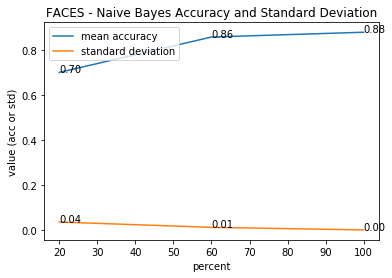

In [19]:
# ======= Naive Bayes ==========
accs_NBC = []
stds_NBC = []
times = []
for i in range(len(percents)):
    acc = np.zeros(5)
    time_ = np.zeros(5)
    for j in range(5):
        c_train, c_labels = getPercentage(train, train_labels, percents[i])
        c_train = c_train.transpose()
        start_time = time.clock()
        pred = NBC(c_train, c_labels, test_MxN)
        time_[j] = time.clock() - start_time
        errorcount, accu = counterror(pred,test_labels)
        acc[j] = accu
    mean = np.mean(acc)
    std = np.std(acc)
    accs_NBC.append(mean)
    stds_NBC.append(std)
    mean_t = np.mean(time_)
    times.append(mean_t)
#print(accs_NBC)
#print(stds_NBC)
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.plot(percents,accs_NBC)
for xy in zip(percents, accs_NBC):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.plot(percents,stds_NBC)
for xy in zip(percents,stds_NBC):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.title('FACES - Naive Bayes Accuracy and Standard Deviation')
plt.ylabel('value (acc or std)')
plt.xlabel('percent')
plt.legend(['mean accuracy','standard deviation'],loc='upper left')
plt.show()
#plt.savefig(image_dir+'/'+'lrcn_accuracy25.png')

(90, 4201)
(150, 4201)
>epoch=0, lrate=0.010, error=27.000
>epoch=1, lrate=0.010, error=6.000
>epoch=2, lrate=0.010, error=3.000
>epoch=3, lrate=0.010, error=2.000
>epoch=4, lrate=0.010, error=1.000
>epoch=5, lrate=0.010, error=3.000
>epoch=6, lrate=0.010, error=2.000
(90, 4201)
(150, 4201)
>epoch=0, lrate=0.010, error=44.000
>epoch=1, lrate=0.010, error=5.000
>epoch=2, lrate=0.010, error=5.000
>epoch=3, lrate=0.010, error=2.000
>epoch=4, lrate=0.010, error=3.000
>epoch=5, lrate=0.010, error=1.000
>epoch=6, lrate=0.010, error=0.000
(90, 4201)
(150, 4201)
>epoch=0, lrate=0.010, error=37.000
>epoch=1, lrate=0.010, error=15.000
>epoch=2, lrate=0.010, error=3.000
>epoch=3, lrate=0.010, error=0.000
>epoch=4, lrate=0.010, error=0.000
>epoch=5, lrate=0.010, error=0.000
>epoch=6, lrate=0.010, error=0.000
(90, 4201)
(150, 4201)
>epoch=0, lrate=0.010, error=36.000
>epoch=1, lrate=0.010, error=12.000
>epoch=2, lrate=0.010, error=3.000
>epoch=3, lrate=0.010, error=0.000
>epoch=4, lrate=0.010, erro

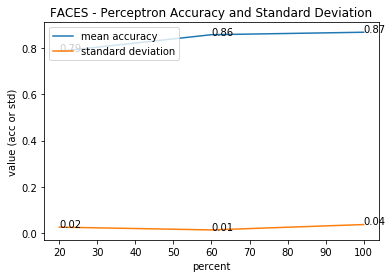

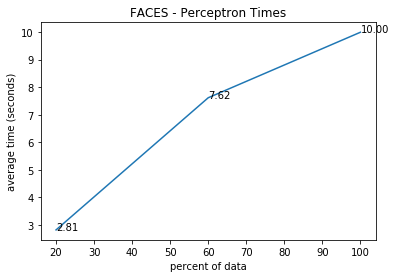

In [20]:
# ======= Perceptron ===========

accs_PC = []
stds_PC = []
times = []
for i in range(len(percents)):
    acc = np.zeros(5)
    time_ = np.zeros(5)
    for j in range(5):
        c_train, c_labels = getPercentage(train, train_labels, percents[i])
        train_data = np.column_stack((c_train,c_labels))
        print(train_data.shape)
        test_data = np.column_stack((test, test_labels))
        print(test_data.shape)
        l_rate = 0.01
        n_epoch = 7
        start_time = time.clock()
        pred = perceptron(train_data, test_data, l_rate, n_epoch)
        time_[j] = time.clock() - start_time
        err, accu = accuracy(test_labels, pred)
        acc[j] = accu
    print(acc)
    mean = np.mean(acc)
    std = np.std(acc)
    accs_PC.append(mean)
    stds_PC.append(std)
    mean_t = np.mean(time_)
    times.append(mean_t)
fig = plt.figure(2)
ax = fig.add_subplot(111)
plt.plot(percents,accs_PC)
for xy in zip(percents, accs_PC):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.plot(percents,stds_PC)
for xy in zip(percents,stds_PC):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.title('FACES - Perceptron Accuracy and Standard Deviation')
plt.ylabel('value (acc or std)')
plt.xlabel('percent')
plt.legend(['mean accuracy','standard deviation'],loc='upper left')
plt.show()

fig2 = plt.figure(3)
ax = fig2.add_subplot(111)
plt.plot(percents,times)
for xy in zip(percents, times):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.title('FACES - Perceptron Times')
plt.ylabel('average time (seconds)')
plt.xlabel('percent of data')
plt.show()


[0.54       0.53333333 0.52       0.58666667 0.51333333]
[0.54666667 0.58       0.58       0.53333333 0.63333333]
[0.58666667 0.58666667 0.58       0.59333333 0.58      ]


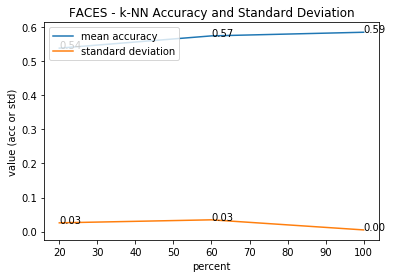

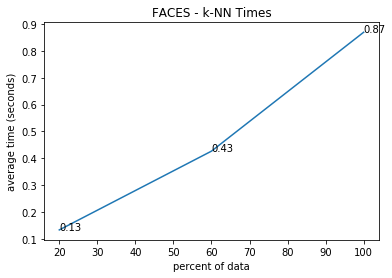

In [21]:
# ================ K-NN ==================
accs_KNN = []
stds_KNN = []
times = []
for i in range(len(percents)):
    acc = np.zeros(5)
    time_ = np.zeros(5)
    for j in range(5):
        c_train, c_labels = getPercentage(train, train_labels, percents[i])
        c_train = c_train.transpose()
        k = 7
        start_time = time.clock()
        ec, e , accu = KNN(k, c_train, c_labels, test_MxN, test_labels)
        time_[j] = time.clock() - start_time
        acc[j] = accu
    print(acc)
    mean = np.mean(acc)
    std = np.std(acc)
    accs_KNN.append(mean)
    stds_KNN.append(std)
    mean_t = np.mean(time_)
    times.append(mean_t)
#print(accs_KNN)
#print(stds_KNN)
fig = plt.figure(3)
ax = fig.add_subplot(111)
plt.plot(percents,accs_KNN)
for xy in zip(percents, accs_KNN):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.plot(percents,stds_KNN)
for xy in zip(percents,stds_KNN):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.title('FACES - k-NN Accuracy and Standard Deviation')
plt.ylabel('value (acc or std)')
plt.xlabel('percent')
plt.legend(['mean accuracy','standard deviation'],loc='upper left')
plt.show()

fig2 = plt.figure(4)
ax = fig2.add_subplot(111)
plt.plot(percents,times)
for xy in zip(percents, times):                                       # <--
    ax.annotate('%.2f' % xy[1], xy=xy, textcoords='data')
plt.title('FACES - k-NN Times')
plt.ylabel('average time (seconds)')
plt.xlabel('percent of data')
plt.show()